In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import vistools          # image visualization toolbox
from skimage import io # read and write images

# global variable for setting the torch.load    map_location
if torch.cuda.is_available():
    loadmap = {'cuda:0': 'gpu'}
else:
    loadmap = {'cuda:0': 'cpu'}
# loadmap = {'cuda:0': 'cpu'}
    
#%matplotlib notebook
# Autoreload external python modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from denoising_helpers import test_denoiser, PSNR
from models import DCTlike, DnCNN_pretrained_grayscale
from models import FFDNet, FFDNet_pretrained_grayscale
from vistools import unzip
from copy import copy
from tqdm import tqdm_notebook as tqdm
import utils

## Implementation of the noise model

Let's note $u(i)$ the intensity of the clean image at the pixel i. For a mixture of Poisson and Gaussian, the general form of the intensity of the noisy image is:
\begin{equation}
u_M(i)= \alpha P_i + N_i
\end{equation}

Where $P_i \sim \mathcal{P}(u(i))$ and $N_i \sim \mathcal{N}(c, \sigma^2)$.
The two variables are independent, hence finding the moments is straightforwards:

\begin{equation*}
\begin{array}{ccl}
\mathbb{E}(u_M(i))&=&\alpha u_i + c\\
\mathbb{V}(u_M(i))&=& \alpha^2 u_i +\sigma^2
\end{array}
\end{equation*}

Note that we in this case the expectation of the intensity of the noisy image does not match the intensity of the clean image, and we may observe a shift in the dynamic range of our picture. To address this problem, we can observe that if we set $z(i)=\frac{u_M(i)-c}{\alpha}$, then the variable $z$ follows the simpler model:
$$
z(i) = P_i + \frac{\sigma}{\alpha} n_i
$$

Where $n_i$ is a standard gaussian variable. So this simple transformation of the noisy input will always help us to go back to the case where $\alpha=1$ and $c=0$. Our implementation of denoising algorithms will make use of this property.

A first approach to handle this mixture of noise is to approximate it by a luminence-dependent Gaussian Noise, for which well-performing denoising algorithms exist. The noise model is then:

\begin{equation}
u_G(i)= u(i) + N_G(i)
\end{equation}

Where this time $N_G(i) \sim \mathcal{N}(0, \sigma(u_i)^2)$.
As the Gaussian distribution is fully characterized by its mean and variance, the closest match of the noise model (1) with the noise model (2) and parameters ($\alpha=1$, $c=0$) is to set $\sigma(u_i)^2= u_i + \sigma^2$. 

From this point the first part of our project aims to:
* Generate synthetic Poisson-Gaussian noise for some input image
* Compare this noise with its closest luminence-dependent Gaussian Noise 
* Compare the performance of Gaussian Denoising on both images: is the Gaussian approximation enough to provide a good denoising performance for the Poisson/Gaussian mixture?

In order to draw comparisons between all methods we are going to use to evaluation criteria:

* The \textit{Peak Signal/Noise Ratio} (PSNR), which is a common metric in denoising and simply depends on the mean squared error between the denoised image and the original one. Note that this metric can only be used on synthetic examples as it is necessary to have the clean image to compute it. 
* The visual quality of the results. In particular, we will eventually notice the presence of artifacts in the image. We will also focus on the blurring of the image, i.e if the strength of the denoising removes a lot of details in the pictures or not

Our implementation of the two types of noise added on an input image:
```python 
def mixture_noise(im, alpha, c, sig):
    poisson = alpha*np.random.poisson(lam=im)
    gaussian = np.random.normal(loc=c, scale=sig, size=im.shape)
    noisy_im = poisson + gaussian
    return minmax(noisy_im)

def gaussian_noise(im, alpha, c, sig):
    n = np.random.normal(size=im.shape)
    return alpha * im + c + np.sqrt(alpha**2 * im + sig**2) * n
```


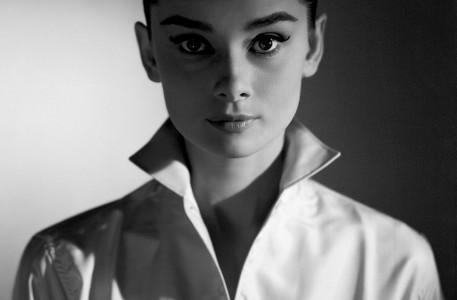
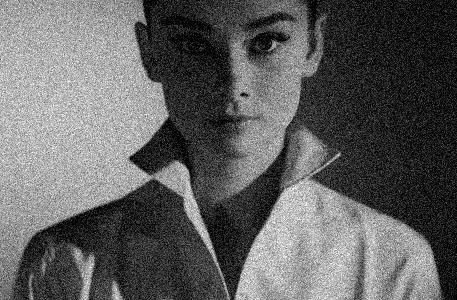
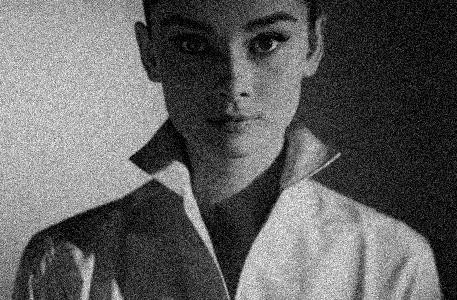

In [3]:
# Test
alpha0, c0, sigma0 = 0.8, 0., 20
im0 = utils.load_generate_noise('images/test010.jpg', alpha=alpha0, c=c0, sigma =sigma0, display=True)

We can visualize the two noise distributions on the total image:

C:\Users\dobau\Anaconda3\envs\py36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


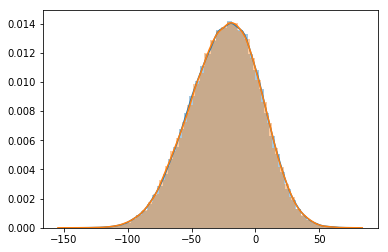

In [3]:
import seaborn
seaborn.distplot((im0[1]-im0[0]).flatten())
seaborn.distplot((im0[2]-im0[0]).flatten())

We can also compare for some intensity level:

C:\Users\dobau\Anaconda3\envs\py36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Expectation/Variance of Mixed Noise 16.055999, 37.345517
Expectation/Variance of Gaussian Noise 16.020513, 37.761457
Expectation/Variance of Mixed Noise 100.009947, 104.070303
Expectation/Variance of Gaussian Noise 100.077066, 105.030629
Expectation/Variance of Mixed Noise 159.841606, 154.697364
Expectation/Variance of Gaussian Noise 159.884251, 151.817931


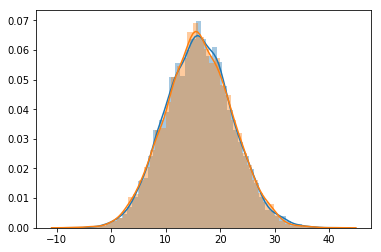

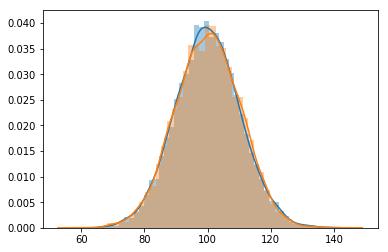

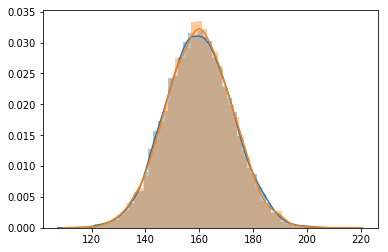

In [4]:
n_test, u, alpha_test, c_test, sig_test = 10000, 150, 0.8, 0., 5
    
utils.plot_dist_noise(20, n_test, alpha_test, c_test, sig_test)
utils.plot_dist_noise(125, n_test, alpha_test, c_test, sig_test)
utils.plot_dist_noise(200, n_test, alpha_test, c_test, sig_test)

With this simple study we can conclude that the Gaussian distribution and the mixture distribution are very similar for all tested Intensity levels. So it seems that a Gaussian approximation of the noise may be relevant.

## First denoising test with DnCNN

We test the performance of the DnCNN denoiser with our synthetic noise. The DnCNN assumes that the noise is gaussian of standard deviation $\sigma$, and performs the denoising with this parameter as input. In this test we ignore the luminance dependancy of the image, just to get a first lower bound of our expectation of performance. That means, instead of considering a standard deviation of $ \sqrt{ u_i + \sigma^2}$ we use the DnCNN corresponding to a noise level of $\sqrt{ \widehat{u_i} + \sigma^2}$ where $\widehat{u_i}$ is the mean intensity on the noisy picture.


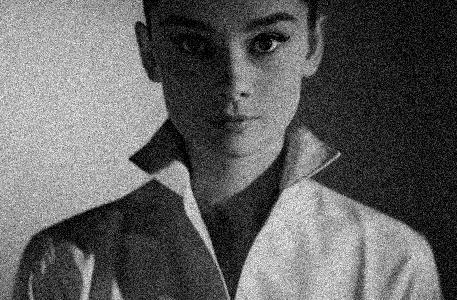
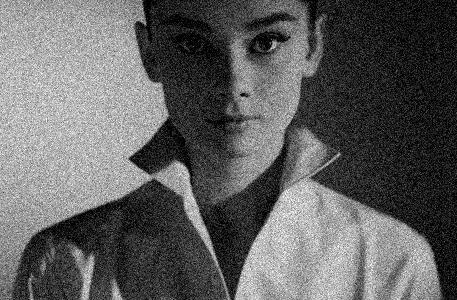
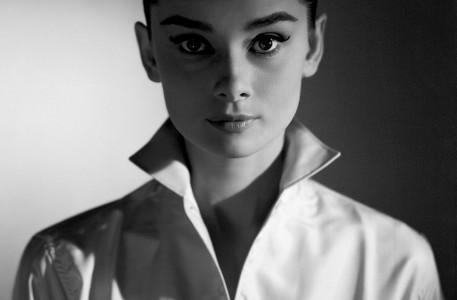
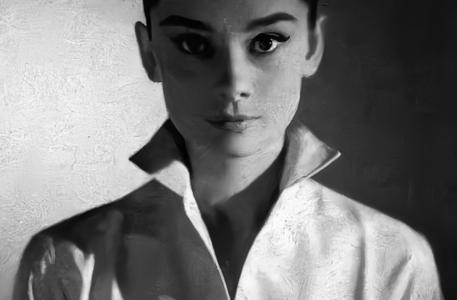
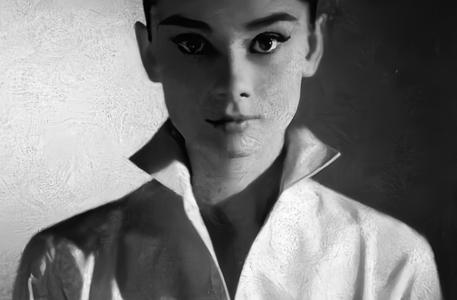

In [5]:
res_raw_dncnn = utils.test_raw_dncnn(alpha0, c0, sigma0, im0, display=True)

We can see that with this very simple approximation the denoisinf quality is not so bad. Much of the noise has been removed but we can remark that some artifacts has been added in homogeneous areas. These artifacts provide a bad visual quality of the denoised image.

## Study of the noise

### Noise map on our example

We display the difference between noisy and clean image to observe the impact of the luminence-dependence of the variance on the noise.


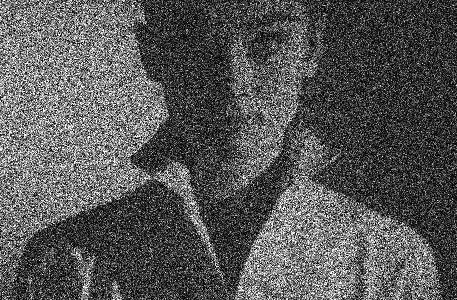
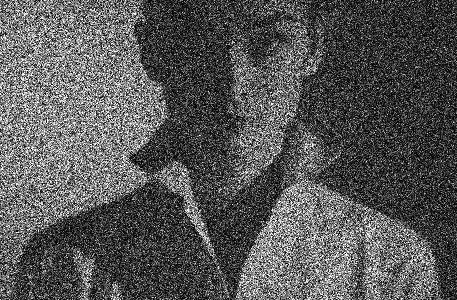

In [6]:
inflate = 3
im1 = utils.load_generate_noise('images/test007.jpg', alpha=alpha0, c=c0, sigma =sigma0, display=False)
vistools.display_gallery([np.abs(im0[1] - im0[0])*inflate, np.abs(im0[2] - im0[0])*inflate])

## Using Gaussian denoiser with Variance Stabilizing (Anscombe) transform

Now we try to perform the simple Anscombe transform for a Gaussian to figure if this transform can be sufficient in our case. As a recall, the transform is computed using a first order Taylor expansion of the denoised image, with a Gaussian approximation. So the main steps of its computation are:

\begin{equation}
\begin{array}{ccl}
VST(y)&=& VST(x + \sigma_x N) \\
&=& VST(x) + VST'(x)\times \sigma_x N 
\end{array}
\end{equation}

This can be performed by normalizing the noisy input to get a mean of $x$, and an equivalent $\sigma$.
After that, as the only source of noise is the Gaussian variable $N$ we only have to find $VST$ such has $VST'(x) \times \sigma_x = C$ for some constant $C$. 

In our case we saw that $\sigma_x = \sqrt{x+ \sigma^2}$, so this leads to $VST(x)= C' \sqrt{x+ \sigma_{eq}^2}$. We implemented this formula below and added a simple affine transform to put the image back in the usual dynamic range.

When we apply the transform, the noise level $\sigma$ used in the Gaussian denoiser is arbitrary fixed by the transform. In our experiments this noise level is set so as to put the transformed image in the same dynamic range as the original one (1-255). So the noise level is set as:
$$
\sigma_{VST}= \frac{255}{2 \times (\sqrt{255+\sigma^2} - \sqrt{1+ \sigma^2})}
$$

``` python
def VST_Gaussian(im, alpha, c, sigma):
    """
    :param im: Input image
    :param sigma: Standard deviation of the Gaussian Noise
    :return: Anscombe transform of the input image, rescaled in (0, 255),
     and the corresponding standard deviation
    """
    im2 = (copy(im) - c)/alpha
    fu = np.sqrt(im2 + (sigma/alpha)**2)
    a = np.sqrt(1 + (sigma/alpha)**2)
    b = np.sqrt(255 + (sigma/alpha)**2)
    return (fu - a)/(b-a)*255., a, b


def inv_VST_Gaussian(im, alpha, c, sigma, param):
    """
    :param im: Output image of a VST
    :param sigma: Standard deviation of the Gaussian Noise
    :param std: Standard deviation of the noise of the transformed image
    :return: Inverse VST Transform
    """
    new_im = copy(im) * (param[1] - param[0])/255. + param[0]
    return new_im**2 - (sigma/alpha) ** 2
```


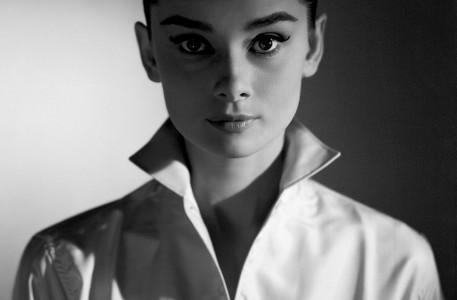
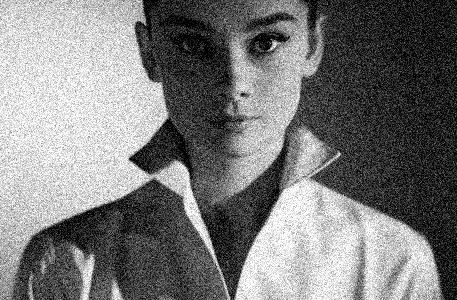
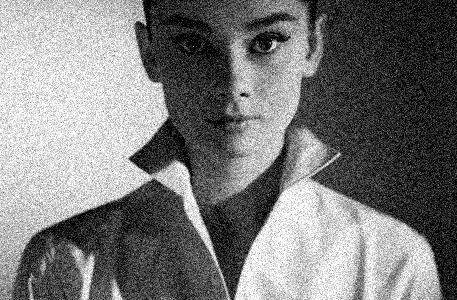


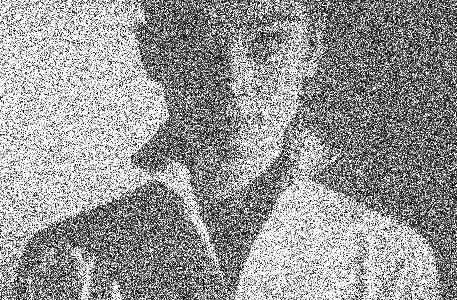
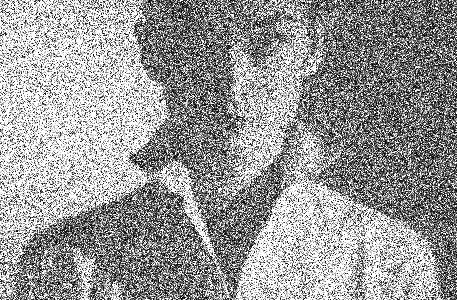

3.979039320256561e-13

In [7]:
utils.test_VST(im0, alpha0, c0, sigma0)
utils.test_VST_bijective(im0[2], alpha0, c0, sigma0)

We see the effect of the transform is to balanced the areas with the values closest to 1 and 255. Moreover, the function "Test VST bijective" that we implemented test if our implementation of the Anscombe transform is correct by successsively applying the Transform and its Inverse on a picture and returning the value of the maximum difference between the intensity of the output image and the original one. Here it is $4.10^{-13}$, which is close enough to zero to be only caused by Python numerical approximations.

Finally, we test here the results of the Anscombe DnCNN compared with the raw DnCNN we tested before. All of the outputs in this picture are taken from the same noisy pictures. As before, we provide both results from a Mixture Noise and for an image with Gaussian Noise.


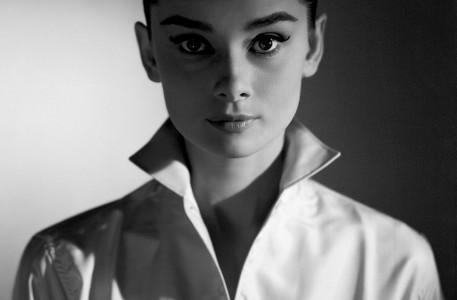
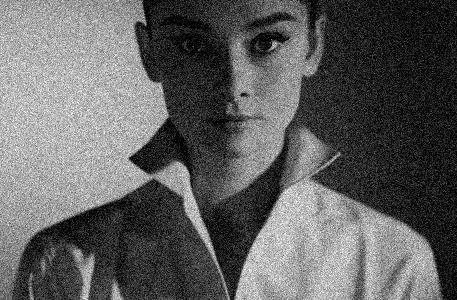
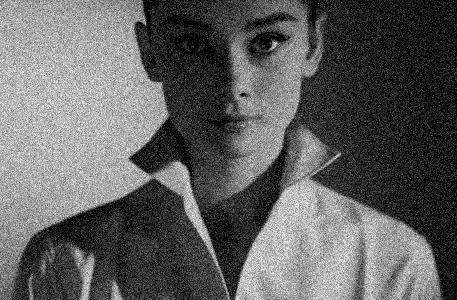
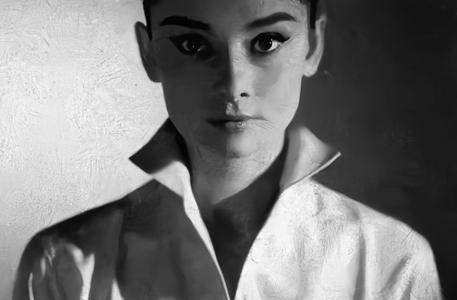
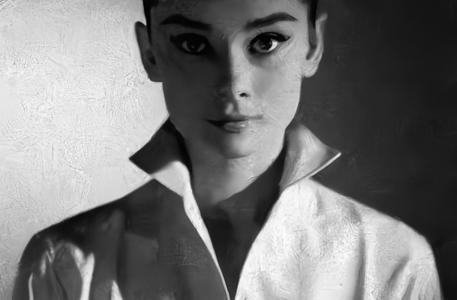
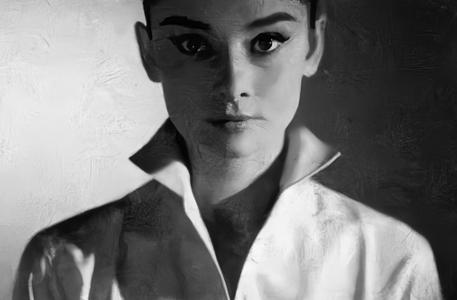
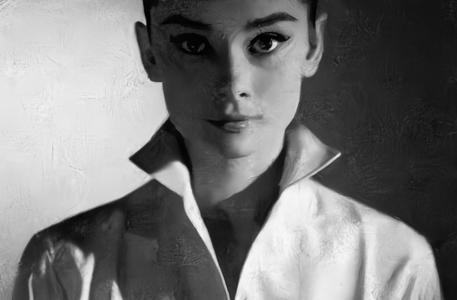

In [4]:
res_test_all_dncnn = utils.test_dncnn_algos('images/test010.jpg', alpha0, c0, sigma0, display=True) 

For both the Mixture Noise and the Gaussian Noise we see that the Anscombe transform much improved both the PSNR and the visual quality of the results. As a first conclusion we can say that:
* The Gaussian approximation seems relevant for the Poisson/Gaussian mixture noise
* The Variance Stabilizing Transform is a simple and efficient method to improve the performance of the denoising, compared with using a Gaussian Denoiser with homogeneous noise directly on the raw noisy input. 

## Another Denoising scheme using our knowledge about the distribution

The Gaussian approximation of the mixed Poisson/Gaussian noise seems to actually work pretty good in our examples. However, we never use the actual distribution of the noise. We can imagine that an algorithm that would be able to use the structure of the mixed Poisson-Gaussian noise would be able to reach better performance. 

The problem is that in practice we only have gaussian denoisers, so we need to continue to use gaussian denoising at some point. The plug-and-play ADMM (Alternative Direction Method of Multiplier)  tries to combine those two aspects by using an iterative scheme involving the Likelihood of the observation under the posterior distribution and a Gaussian denoiser.

The aim of the ADMM is to approximate the Maximum A Posteriori problem:
$$ 
\max_x f(y|x) + \lambda g(x)
$$
Where f is the loglikelihood of the noisy observation and g is the prior distribution of the intensity of a pixel. The notation with $\lambda$ aims to add an interpretation of the prior in the MAP problem as a regularization condition. The ADMM algorithm tackles two problems, the first one is that the MAP computation is untractable. The proposed solution is to add a slack variable $v$ to the problem and set $x=v$ as a condition on the solution: 
$$ 
\max_x f(y|x) + \lambda g(v)
$$

Writing the dual problem of this optimization problem and adding a second regularization as a squared distance leads to the augmented Lagrangian function:

\begin{equation}
    \mathcal{L}(x, v, u)= f(x) + \lambda g(v) + u^T (x-v) + \frac{\rho}{2}||x-v||^2
\end{equation}

It can be shown that a solution of this problem can be found with the following iterative scheme:

* Set $x^{(k+1)}=\text{argmin }f(x) + \rho^{(k)}/2 \times ||x-v^{(k)}+ u^{(k)}||^2 $
* Set $v^{(k+1)}= \text{argmin}_v \lambda g(v) + \frac{\rho^{(k)}}{2} ||v-v^{k}||^2$
* Set $u^{(k+1)}= u^{(k)} + x^{(k+1)}- v^{(k+1)} $
* Update $\rho^{(k)}$, $\sigma^{(k)}=\sqrt{\lambda/\rho^{(k)}}$  

The initial values of $x$, $v$ and $u$ can be arbitrary. The parameter $\rho$ is updated according to a \textit{continuation scheme} (i.e potentially increased at each iteration according to some fixed update rule). $\rho$, $\lambda$ and the continuation rules need to be $\textbf{properly tuned}$.

The second problem is that we have actually no information about potential good priors, for the function $g$. The last improvement of the ADMM scheme is to replace the second step of optimization of $g$ by a $\textbf{Denoising step}$, using our Gaussian denoiser. So the update of $v$ becomes:

$$
v^{(k+1)} = D_{\sigma_k}(x^{(k+1)}+u^{(k)}) 
$$
Where $D_{\sigma_k}$ is the Gaussian Denoiser associated with a noise level of $\sigma_k$. In our case it is again a DnCNN.

We propose an implementation of this algorithm below.

The main difficulty in this algorithm is the update of the variable $x$. Indeed, it requires to compute the maximum posterior log-likelihood of the noisy observation, which is a convolution of a Gaussian and a Poisson variable. This computation is expensive and a continuous maximization seems untractable. For this reason, we first wrote some functions to compute the probabilities for each pixel value $(x, y) \in [1,255] \times [1, 255]$. Then we approximate all likelihoods by the likelihoods of the rounding integer of each value.

``` python
from scipy.stats import poisson
from scipy.stats import norm

def logp_scipy(x, y, alpha, c, sigma, tol=1e-4):
    p = poisson(x)
    n = norm(y-c, sigma)
    max_range = np.sqrt(-2*sigma**2*np.log(tol))
    k_range = np.arange(max(int((y-c-max_range)/alpha), 0), min(int((y-c+max_range)/alpha), 300))
    prob_list = np.zeros(k_range.shape[0])
    for i, k in enumerate(k_range):
        prob_list[i] = p.logpmf(k) + n.logpdf(alpha * k)
    a = prob_list.max()
    return a + np.log(np.exp(prob_list-a).sum())
```

```python
def update_x(im, prob, rho, u, v):
    """
    :param im: Noisy Image
    :param prob: grid of observation conditional likelihood
    :param rho: strength of regularization
    :param u: Lagrange multiplier
    :param v: Slack variable for x
    :return: New value of x maximizing regularized log-likelihood
    """
    new_x = np.zeros(im.shape)
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            y = im[i, j]
            index = max(1, min(255, int(round(y, 0))))
            obj = -prob[:, index-1] + rho/2 * (np.arange(1, 256) - v[i, j] + u[i, j])**2
            new_x[i, j] = obj.argmin()
    return new_x


def ADMM(im, alpha, c, sigma, denoiser, l, param, tol, max_iter, im_clean):
    """
    :param im: Input Image
    :param alpha: Underlying model scaling of poisson noise
    :param c: Underlying model mean of the gaussian noise
    :param sigma: Underlying model noise
    :param denoiser: Denoising algorithm class used in test_denoiser, is instanced with a certain sigma
    at each iteration
    :param l: Regularization parameter
    :param param: Parameters of the continuation scheme (rho, eta, gamma): Starting value, update criterion
    and update rate
    :param tol: tolerance for convergence
    :param max_iter: maximum number of loops before stopping the algorithm
    :return:
    """
    delta = tol + 0.01
    rho, eta, gamma = param
    n_iter = 0
    # x = np.random.uniform(0, 255, size=im.shape)
    im = (copy(im) - c)/alpha
    x = copy(im)
    prob_array = read_proba_grid(int(sigma/alpha), best_match=True)
    v, u = copy(x), np.zeros(im.shape)
    pbar = tqdm(total=max_iter)
    out_x, out_v = [], []
    PSNR_x, PSNR_v = [], []
    while delta > tol and n_iter < max_iter:
        n_iter += 1
        xp, vp, up, delta_p = copy(x), copy(v), copy(u), copy(delta)
        x = update_x(im, prob_array, rho, u, v)
        sig_denoiser = np.sqrt(l/rho)
        v = test_denoiser(denoiser(sig_denoiser), x+u, None, has_noise=True)[0]
        v = v[0, 0, :, :].numpy()
        u += x - v
        delta = compute_delta(x, v, u, xp, vp, up)
        if delta >= eta * delta_p:
            rho *= gamma
        pbar.update(1)
        out_x.append(x)
        out_v.append(v)
        if im_clean is not None:
            PSNR_x.append(PSNR(x, im_clean))
            PSNR_v.append(PSNR(v, im_clean))
    return (x+v)/2, out_x, out_v, PSNR_x, PSNR_v
```

We propose a test of our method below. We performed a Gridsearch (that we do not display here for better readability) to find the parameters that are tested below. However, better parameters may be found by exploring some parts of the parameters space that we did not tested.

In [5]:
res_ADMM = utils.ADMM(im0[1], alpha0, c0, sigma0, DnCNN_pretrained_grayscale,
               l=1., param=(1e-3, 0.85, 1.5), tol=1e-3, max_iter=10, im_clean=im0[0])


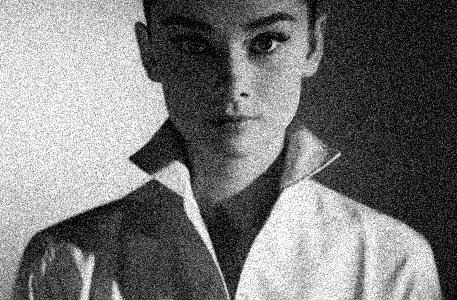
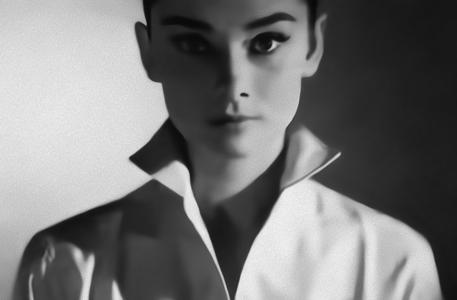
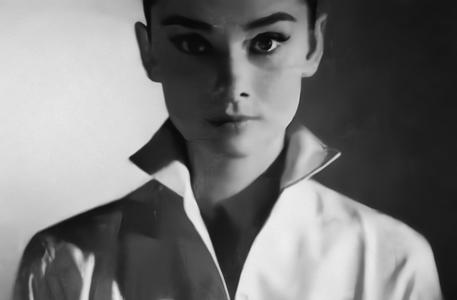
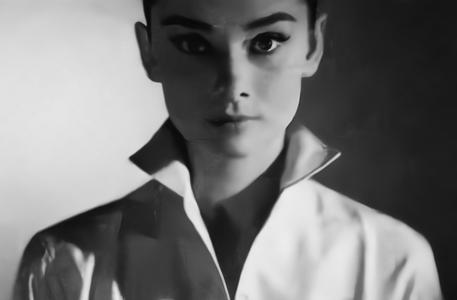
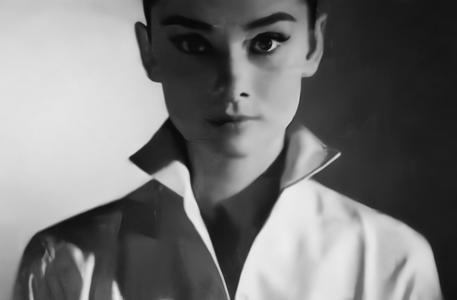
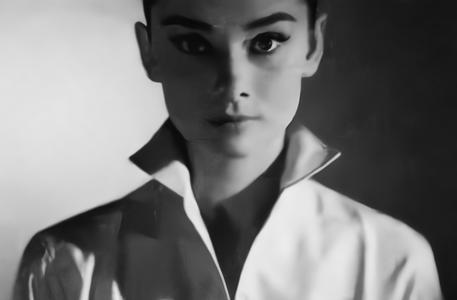
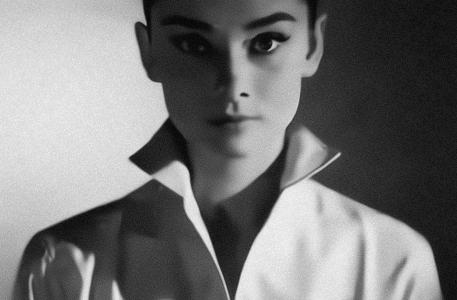
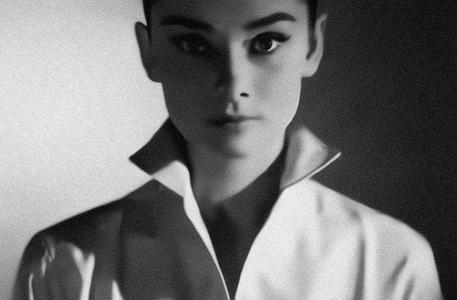
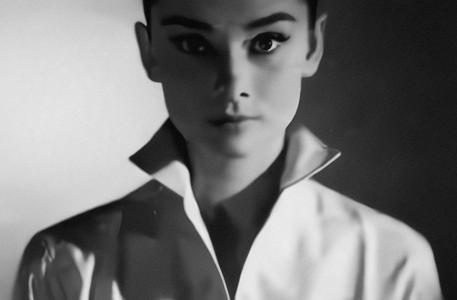
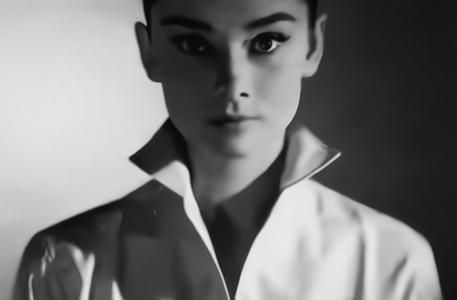


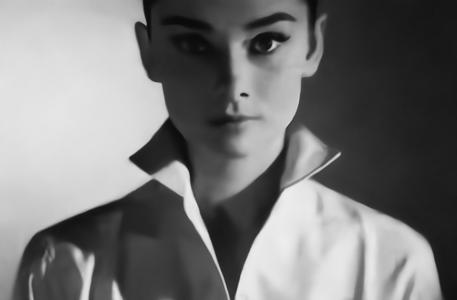
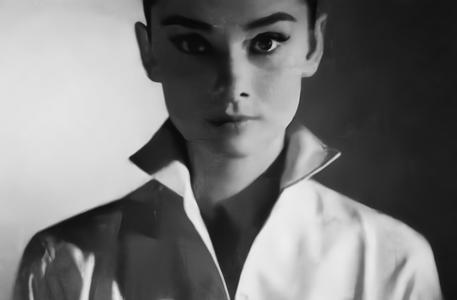
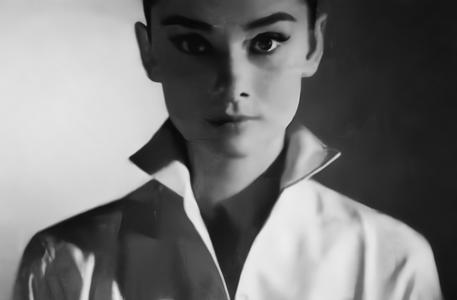
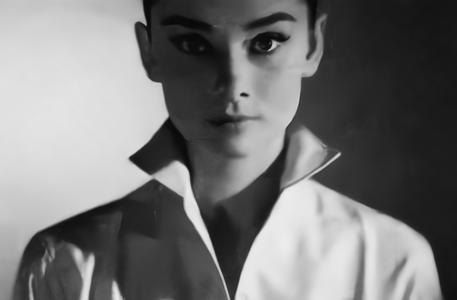
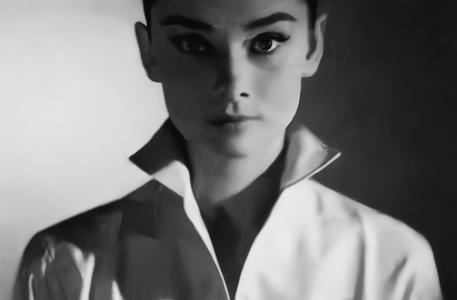
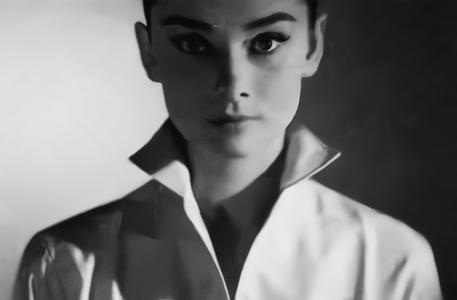
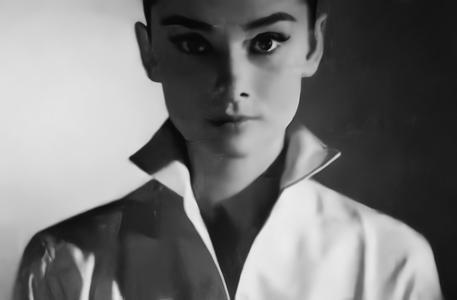
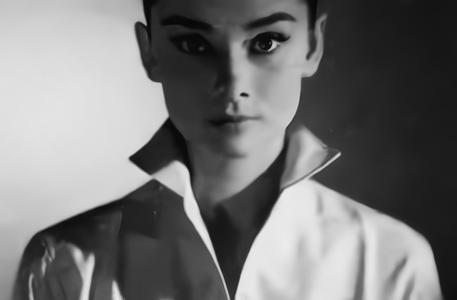
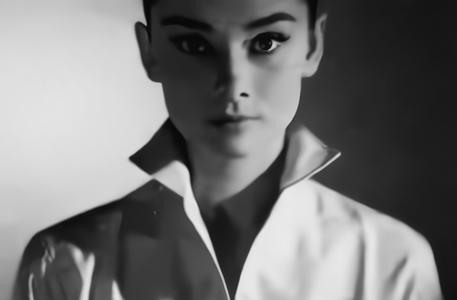
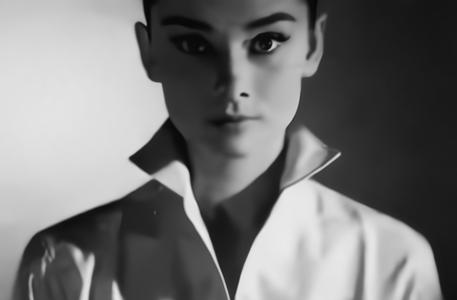

[20.03480754431169, 33.273697006287, 33.912719002192944, 33.899998375540285, 33.844037283455094, 33.79557714477812, 31.229664554043772, 30.322455425695694, 33.26334671299703, 33.5756879090075]
[34.1779073013786, 34.20527490797761, 34.062240928028075, 33.94573503786325, 33.86777527871074, 33.816488612885486, 33.78713402149622, 33.853043291414664, 33.78817737951414, 33.6986686833526]


In [7]:
vistools.display_gallery(res_ADMM[1])
vistools.display_gallery(res_ADMM[2])
print(res_ADMM[3])
print(res_ADMM[4])

Our remarks about these results are:
* The main denoising is made at the first denoising step: we observe a great increase of the PSNR at this step and the output of this step is already a picture that looks like the clean one
* The results of the ADMM have a worse PSNR than the VST method. However, the visual quality of the results is better as most artifacts present with the VST are removed by the ADMM. This is in our opinion a main interest of the ADMM method
* The computational burden of the likelihood makes the algorithm much slowier than the ADMM. The approximation of the likelihood using a grid add some uncertainty, so maybe the results would be better with an exact computation. Unfortunately, it is untractable without some approximation (one could think of a Gaussian approximation again for instance).

# Comparing all of the algorithms

Finally, we tested all of our algorithms with a different set of pictures.


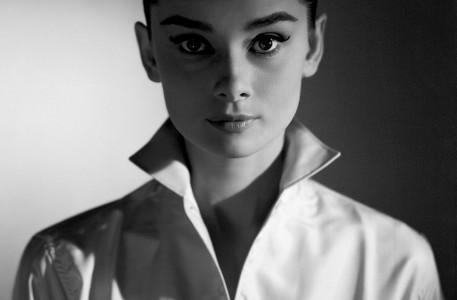
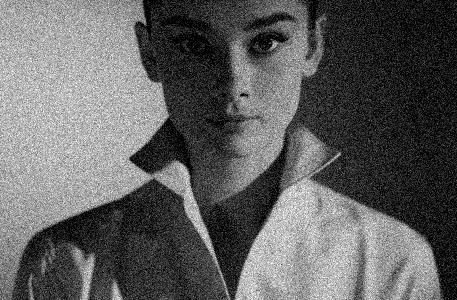
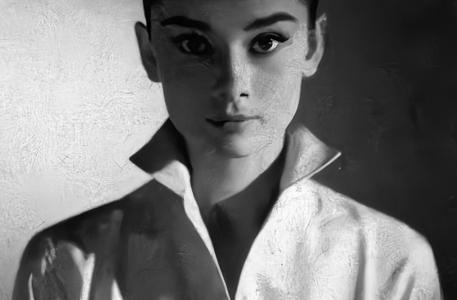
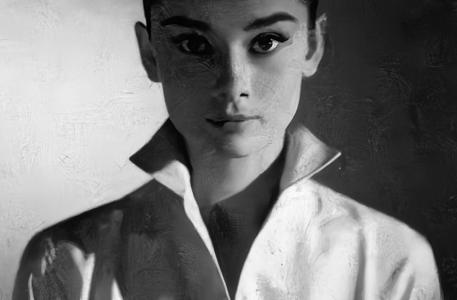
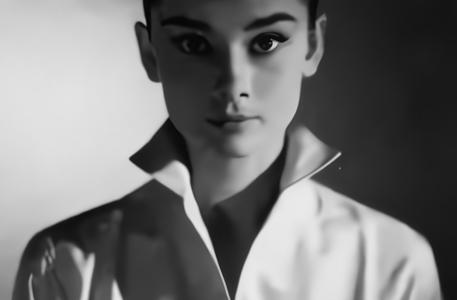

In [25]:
name = 'images/test010.jpg'
alpha, c, sigma = 0.8, 0., 20
param_ADMM = {'denoiser': DnCNN_pretrained_grayscale, 'l': 1. , 
              'param': (1e-3, 0.85, 1.5) , 'tol': 1e-3, 'max_iter': 10}

res = utils.test_all_algos(name, alpha, c, sigma, param_ADMM, display=True, mixture_only=True)


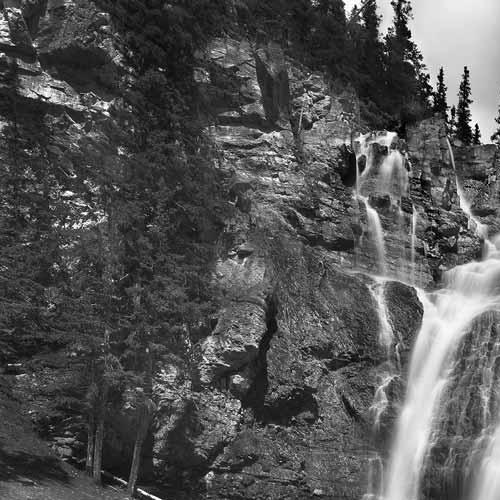
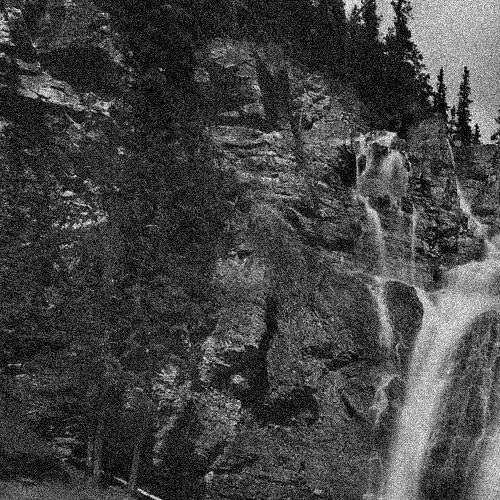
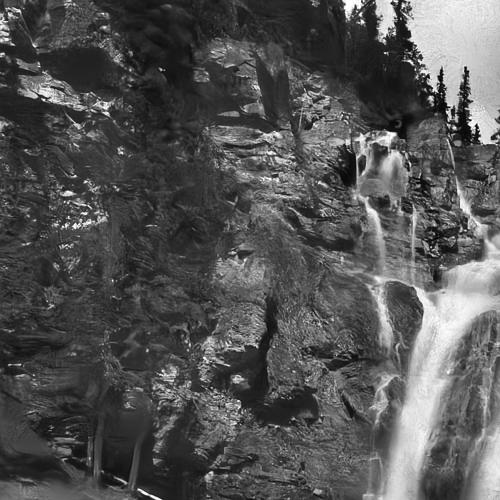
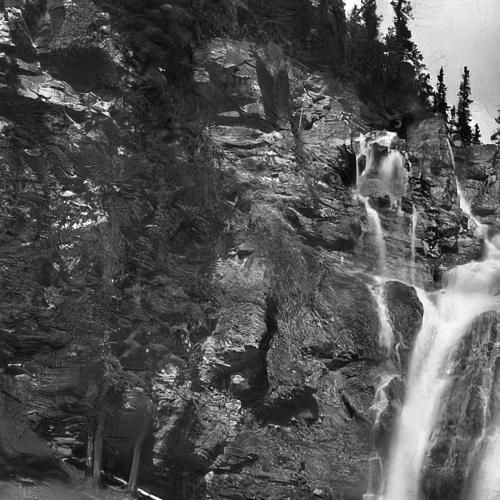
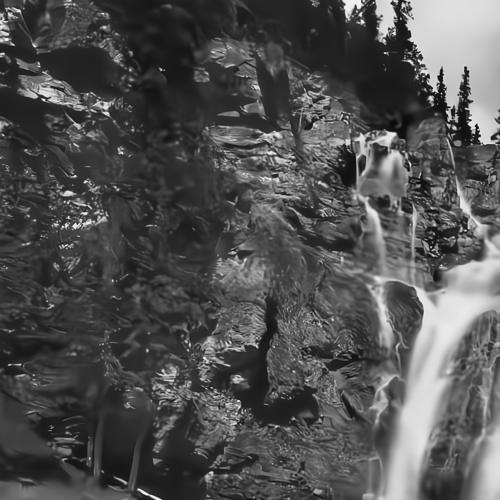

In [22]:
name = 'images/test012.jpg'
alpha, c, sigma = 0.8, 0., 20
param_ADMM = {'denoiser': DnCNN_pretrained_grayscale, 'l': 1. , 
              'param': (1e-3, 0.85, 1.5) , 'tol': 1e-3, 'max_iter': 10}

res = utils.test_all_algos(name, alpha, c, sigma, param_ADMM, display=True, mixture_only=True)


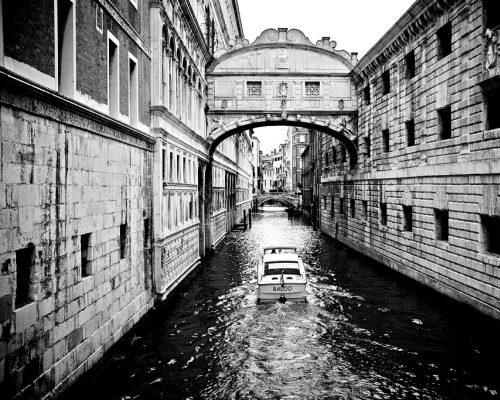
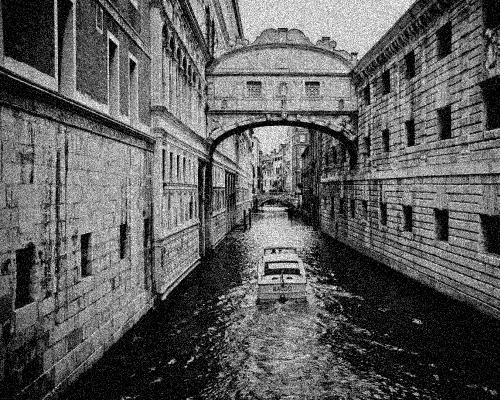
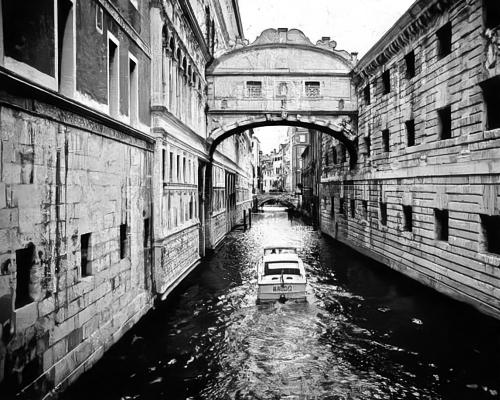
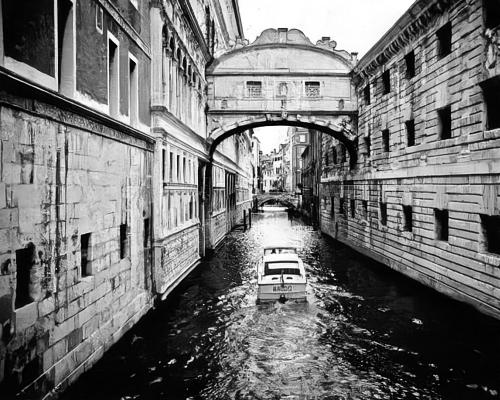
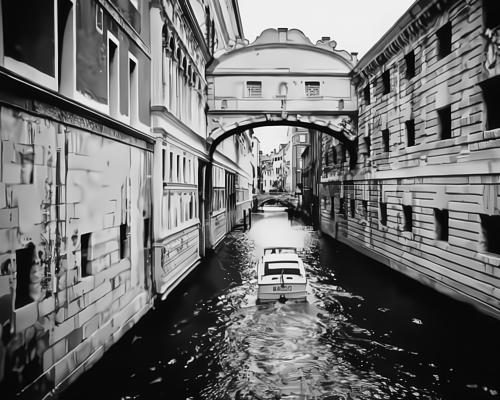

In [42]:
name = 'images/test013.jpg'
alpha, c, sigma = 0.8, 0., 20
param_ADMM = {'denoiser': DnCNN_pretrained_grayscale, 'l': 1. , 
              'param': (1e-3, 0.85, 1.5) , 'tol': 1e-3, 'max_iter': 10}

res = utils.test_all_algos(name, alpha, c, sigma, param_ADMM, display=True, mixture_only=True)


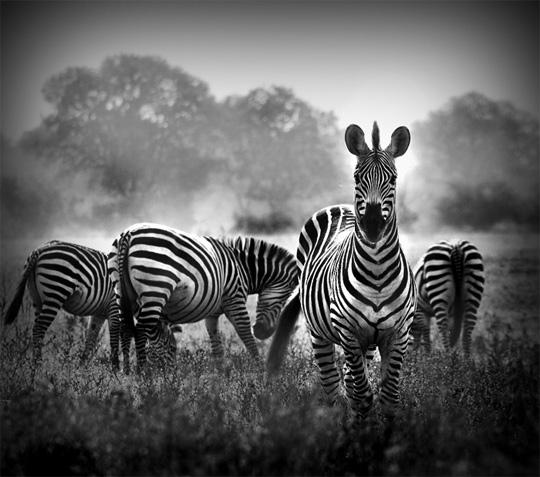
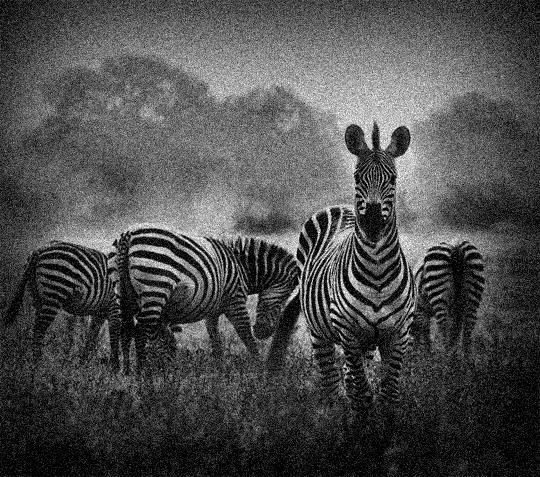
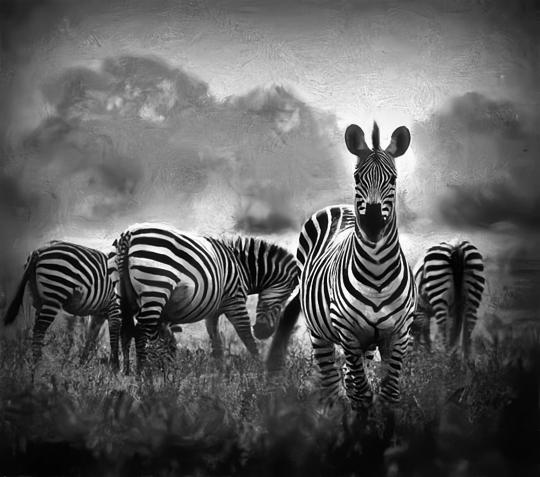
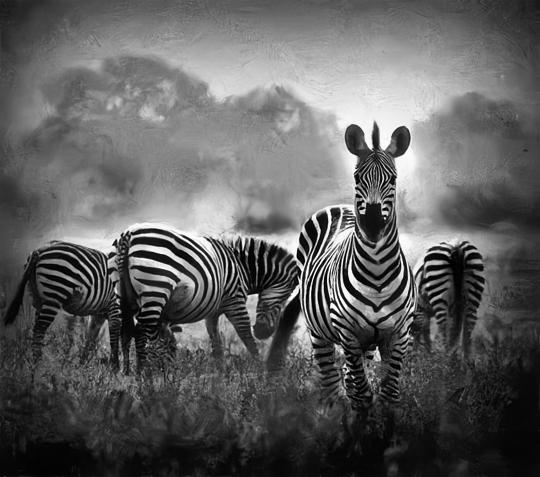
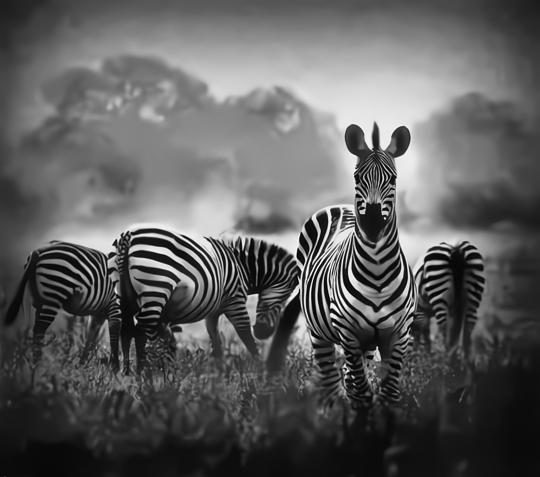

In [14]:
name = 'images/test014.jpg'
alpha, c, sigma = 0.8, 0., 20
param_ADMM = {'denoiser': DnCNN_pretrained_grayscale, 'l': 1. , 
              'param': (1e-3, 0.85, 1.5) , 'tol': 1e-3, 'max_iter': 10}

res = utils.test_all_algos(name, alpha, c, sigma, param_ADMM, display=True, mixture_only=True)


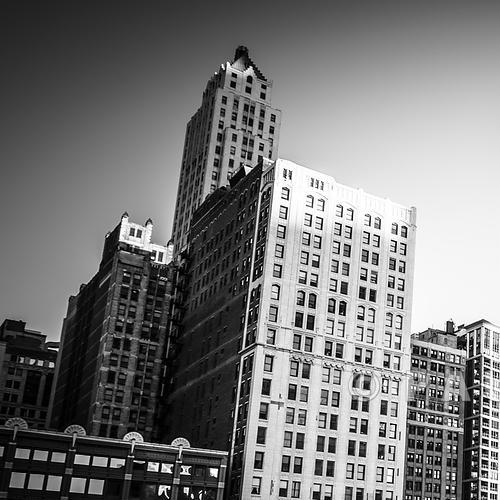
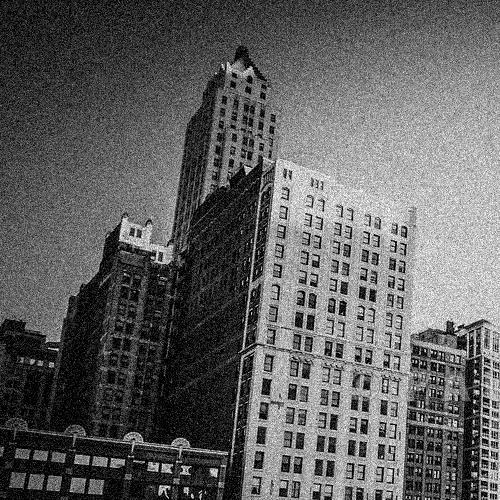
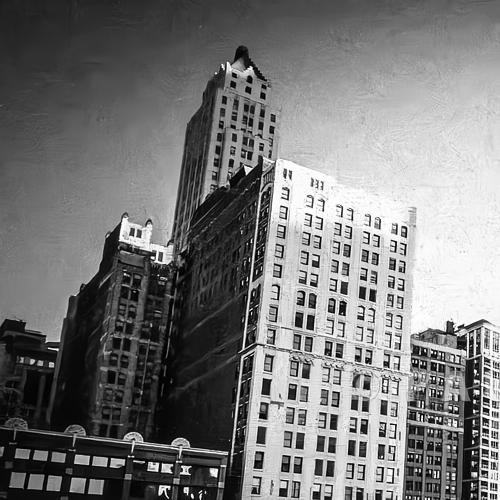
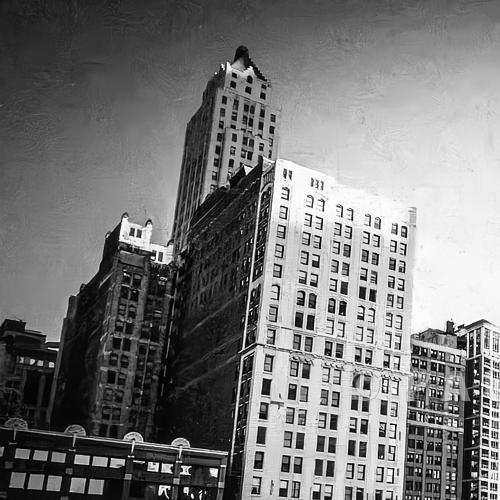
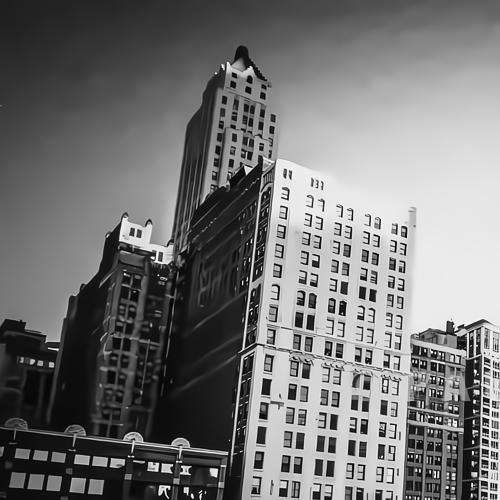

In [24]:
name = 'images/test015.jpg'
alpha, c, sigma = 0.8, 0., 20
param_ADMM = {'denoiser': DnCNN_pretrained_grayscale, 'l': 1. , 
              'param': (1e-3, 0.85, 1.5) , 'tol': 1e-3, 'max_iter': 10}

res = utils.test_all_algos(name, alpha, c, sigma, param_ADMM, display=True, mixture_only=True)

# General Conclusions

In this project we compared the performance of different denoising schemes involving Gaussian denoisers with homogeneous noise with a non homogeneous Gaussian/Poisson mixture noise.

Our lower bound of the performance is to directly input the noisy image in a Gaussian Denoiser tuned for the mean standard deviation of the picture. It is already able to remove much of the noise but the artifacts make the visual quality very poor with this technic.

The Variance Stabilizing Transform (Anscombe) is a fast and efficient technic to take into account the Luminence-dependancy of the noise and still be able to use the Gaussian Denoiser at hand. The PSNR is generally better with this method, but we can still observe a lot of artifacts when the level of noise becomes too high. When the level of noise is low, however, this method performs very well.

Finally, we introduced the ADMM scheme to drop the Gaussian approximation and take into account the real distribution of the noise. This method leads to good results, in particular we observe that the artifacts of the DnCNN are removed with this method. However, it has important drawbacks that can limit its practical use. The first one is the computational time to run the algorithm: an exact computation is untractable, hence we approximated the distribution using pre-computed grids. This can add some uncertainty to the results. One could check an approximate computation using again a Gaussian approximation, but this removes the fact of being able to use the true noise structure. Secondly, the convergence can be very slow. 
    The second drawback is that in order to achieve good performance every parameter needs to be properly tuned. This tuning depends both on the noise level and on the actual image to denoise (different grisearches with different images did not lead to the exact same sets of optimal parameter). Again, the need to tune the algorithm can limit its use in practical case.
    
    
  Finally, our conclusion is that the choice of using the Variance Stabilizing Transform or the ADMM may highly depend on the practical application of the denoising:
  * For a fast computation and if the objective is to maximize the PSNR we would recommend to use the VST scheme
  * If the computation time is not a problem and we only want to achieve a good visual quality of the result then the ADMM seems more appropriate
  